In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE, mutual_info_regression
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU, MaxPooling1D, Flatten, Conv1D, Reshape
from sklearn.model_selection import train_test_split
from keras import layers
import copy

In [13]:
import datetime
import json
import requests

start_date = '2016-10-01'
start_date = pd.to_datetime(start_date).date()
end_date = dt.date.today()
df = yf.download("AMZN", start=start_date, end=end_date, auto_adjust=True)
df.columns = [i.lower() for i in df.columns]
df = df.resample('D').interpolate()

#load historical fear and greed data from fear-greed.csv
fear_greed_historical = pd.read_csv('fear-greed.csv')
fear_greed_historical = fear_greed_historical.drop(columns=['Open', 'High', 'Low'])
fear_greed_historical['Date'] = pd.to_datetime(fear_greed_historical['Date'])
fear_greed_historical['Date'] = fear_greed_historical['Date'].dt.date

#get latest fear and greed index data
url = 'https://api.alternative.me/fng/?limit=0'
response = requests.get(url)
data = response.text
data = json.loads(data)
values = [(int(entry['timestamp']), float(entry['value'])) for entry in data['data']]

fear_greed = pd.DataFrame(values, columns=['timestamp', 'fear_greed_index'])
fear_greed['Date'] = pd.to_datetime(fear_greed['timestamp'], unit='s')
fear_greed['Date'] = fear_greed['Date'].dt.date
fear_greed = fear_greed.drop(columns=['timestamp'])

#merge the fear_greed with the historical fear greed index with fear_greed having priority
fear_greed = pd.concat([fear_greed, fear_greed_historical], ignore_index=True)
fear_greed = fear_greed.drop_duplicates(subset=['Date'], keep='last')
fear_greed = fear_greed.set_index('Date')
fear_greed.index = pd.to_datetime(fear_greed.index)
fear_greed = fear_greed.sort_index()

df_end = df.index[-1]
# get rid of rows indexed by dates before the start of the stock data
fear_greed = fear_greed.loc[start_date:df_end]

#fill in the missing dates by copying values from the previous day
fear_greed = fear_greed.resample('D').interpolate()

df['fear_greed'] = fear_greed['fear_greed_index']

[*********************100%%**********************]  1 of 1 completed


In [14]:
df['daily_varitation'] = (df['high'] - df['low'])/df['open']
df['timestamp'] = df.index.astype(np.int64) // 10**9
df['daily_return'] = df['close'].pct_change()
df['7day_sma'] = df['close'].rolling(window=7).mean()
df['7day_std'] = df['close'].rolling(window=7).std()
df['7day_sma+2std'] = df['7day_sma'] + 2*df['7day_std']
df['7day_sma-2std'] = df['7day_sma'] - 2*df['7day_std']
df['high_close_diff'] = df['high'] - df['close']
df['low_open_diff'] = df['low'] - df['open']
df['14day_ema'] = df['close'].ewm(span=14, adjust=False).mean()
# df['rsi'] = 100 - (100 / (1 + (df['close'].diff().fillna(0).rolling(window=14).apply(lambda x: x[x > 0].sum(), raw=True) / df['close'].diff().fillna(0).rolling(window=14).apply(lambda x: x[x < 0].sum(), raw=True))))
df['macd'] = df['close'].ewm(span=12, adjust=False).mean() - df['close'].ewm(span=26, adjust=False).mean()
df['stochastic_oscillator'] = (df['close'] - df['low'].rolling(window=14).min()) / (df['high'].rolling(window=14).max() - df['low'].rolling(window=14).min())
df['atr'] = df[['high', 'low', 'close']].apply(lambda x: max(x['high'] - x['low'], abs(x['high'] - np.roll(x['close'], 1)), abs(x['low'] - np.roll(x['close'], 1))), axis=1)
df['cci'] = (df['close'] - df['close'].rolling(window=20).mean()) / (0.015 * df['close'].rolling(window=20).std())
df['williams_r'] = (df['high'].rolling(window=14).max() - df['close']) / (df['high'].rolling(window=14).max() - df['low'].rolling(window=14).min())
df['bollinger_bands'] = (df['close'] - df['close'].rolling(window=20).mean()) / (2 * df['close'].rolling(window=20).std())
df['price_rate_of_change'] = df['close'].pct_change(periods=9)
df['momentum'] = df['close'] - df['close'].shift(4)
df['roc'] = (df['close'] - df['close'].shift(12)) / df['close'].shift(12)
df['obv'] = (df['volume'] * np.sign(df['close'].diff())).cumsum()
df['obv_ema'] = df['obv'].ewm(span=20, adjust=False).mean()
df['obv_roc'] = df['obv'].pct_change()
df['obv_roc_ema'] = df['obv_roc'].ewm(span=20, adjust=False).mean()
df['obv_roc_diff'] = df['obv_roc'] - df['obv_roc_ema']

#print rows containing nan values
import pandas as pd

#getting rid of NaN containing rows at the beginning
df = df[df.index >= '2016-11-04']
print(df.info())
rows_with_nan = df[df.isnull().any(axis=1)]

print(rows_with_nan)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2752 entries, 2016-11-04 to 2024-05-17
Freq: D
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   open                   2752 non-null   float64
 1   high                   2752 non-null   float64
 2   low                    2752 non-null   float64
 3   close                  2752 non-null   float64
 4   volume                 2752 non-null   float64
 5   fear_greed             2752 non-null   float64
 6   daily_varitation       2752 non-null   float64
 7   timestamp              2752 non-null   int64  
 8   daily_return           2752 non-null   float64
 9   7day_sma               2752 non-null   float64
 10  7day_std               2752 non-null   float64
 11  7day_sma+2std          2752 non-null   float64
 12  7day_sma-2std          2752 non-null   float64
 13  high_close_diff        2752 non-null   float64
 14  low_open_diff          2752 no

In [15]:
# you need to run this \/ (to be added to anaconda)
# pip install nltk 

nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()

articles = pd.read_csv('articles.csv')

articles_dict = {}
for index, row in articles.iterrows():
    date = row['date']
    if date in articles_dict:
        articles_dict[date].append(row['title'])
    else:
        articles_dict[date] = [row['title']]

sentiments = []
for index, row in df.iterrows():    
    date = index.strftime('%Y-%m-%d')
    sentiment = 0
    count = 0
    if date in articles_dict:
        for article in articles_dict[date]:
            sentiment += analyzer.polarity_scores(article)['compound']
            count += 1
    if (count > 0):
        sentiment = sentiment / count
    sentiments.append(sentiment)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\48503\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [16]:
# print non zero sentiments
non_zero_sentiments = [sentiment for sentiment in sentiments if sentiment != 0]
print(non_zero_sentiments)
print(sentiments)
df['sentiment'] = sentiments

[0.09353333333333334, 0.5994, 0.15595, -0.013066666666666671, -0.082725, 0.15337142857142858, -0.019033333333333347, -0.5574, 0.13073333333333334, 0.2066125, 0.38695, 0.4224, 0.16138, 0.09, 0.55115, 0.0431, 0.1645625, -0.050614285714285716, 0.0593, 0.2678, 0.20355714285714285, 0.17649999999999996, 0.15568888888888888, 0.1779, -0.3182, 0.18386666666666668, 0.12734, 0.23537999999999998, -0.11234999999999998, 0.4201, 0.06743333333333333, 0.1278, 0.1147083333333333, 0.06620000000000001, 0.08895, -0.32389999999999997, 0.10846, 0.4074, 0.09276666666666666, 0.264025, 0.3767, -0.14920000000000003, 0.43392499999999995, 0.044475, 0.5994, 0.1779, 0.14894285714285713, -0.26934, -0.05403333333333334, 0.08084, 0.28595, 0.093, 0.04845384615384617, -0.09090000000000001, -0.2023, 0.36605, 0.6078749999999999, -0.23835, 0.22555, 0.3612, 0.1806, 0.012499999999999999, 0.47569999999999996, 0.1027, -0.3412, 0.2899, 0.12050000000000001, 0.20966666666666667, -0.19466, 0.08954375, -0.33140000000000003, -0.32321

c:\programming\ml\my_env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.044e+00, tolerance: 1.032e-03
  model = cd_fast.enet_coordinate_descent(


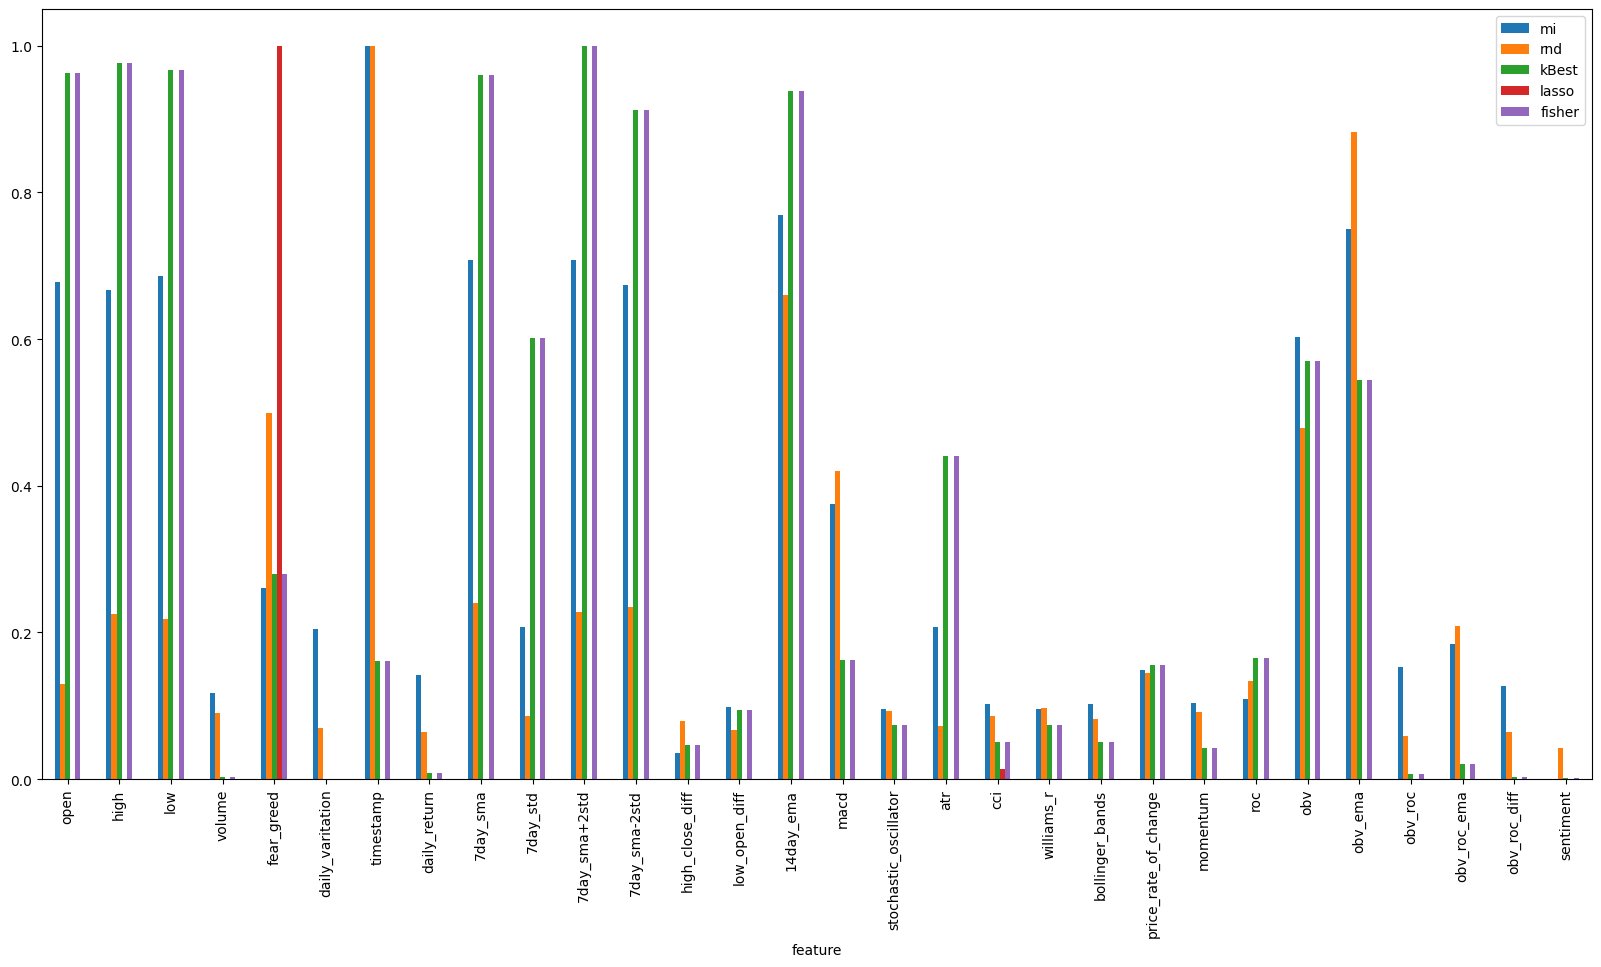

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2752 entries, 2016-11-04 to 2024-05-17
Freq: D
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   open                   2752 non-null   float64
 1   high                   2752 non-null   float64
 2   low                    2752 non-null   float64
 3   close                  2752 non-null   float64
 4   volume                 2752 non-null   float64
 5   fear_greed             2752 non-null   float64
 6   daily_varitation       2752 non-null   float64
 7   timestamp              2752 non-null   int64  
 8   daily_return           2752 non-null   float64
 9   7day_sma               2752 non-null   float64
 10  7day_std               2752 non-null   float64
 11  7day_sma+2std          2752 non-null   float64
 12  7day_sma-2std          2752 non-null   float64
 13  high_close_diff        2752 non-null   float64
 14  low_open_diff          2752 no

In [17]:

# evaluate the relevance of features using non-neural network models
return_period = 30
X = df.drop(columns=['close'])
y = np.log(df['close']).diff(return_period).shift(-return_period)


y = y.dropna()
#get rid of 5 rows at the end of the dataframe
X = X.iloc[:-return_period]

data = pd.concat([X, y], axis=1)

#mutual information
mi = mutual_info_regression(X, y)

#kBest
test = SelectKBest(score_func=f_regression, k='all')
fit = test.fit(X, y)

#lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X, y)
coef = np.abs(lasso.coef_)

#random forest
rnd_clf = RandomForestRegressor(n_estimators=500, n_jobs=-1)
rnd_clf.fit(X, y)

#fishers score
fisher_score = f_regression(X, y)

results = pd.DataFrame({'feature': X.columns.values, 'mi': mi,'rnd': rnd_clf.feature_importances_, 'kBest': fit.scores_, 'lasso': coef, 'fisher': fisher_score[0]})

#scale the results to be able to compare them
results['mi'] = results['mi']/results['mi'].max()
results['rnd'] = results['rnd']/results['rnd'].max()
results['kBest'] = results['kBest']/results['kBest'].max()
results['lasso'] = results['lasso']/results['lasso'].max()
results['fisher'] = results['fisher']/results['fisher'].max()

# output the results in a graph with columns representing each method next to each other
results.plot(x='feature', y=['mi', 'rnd', 'kBest', 'lasso', 'fisher'], kind='bar', figsize=(20,10))
plt.show()

#show the amount of rows
print(df.info())

print(data)
    

In [18]:
def create_enhanced_lstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def create_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(GRU(50))
    model.add(Dropout(0.2))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def create_cnn_lstm_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(Reshape((1, -1)))
    model.add(LSTM(50))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def evaluate_features(X_train, X_test, y_train, y_test, baseline_model):
    # Baseline model
    baseline_model.fit(X_train, y_train, epochs=300, batch_size=2197, verbose=0)

    # Evaluate baseline model
    baseline_performance = baseline_model.evaluate(X_test, y_test, verbose=0)
    print(f'Baseline performance: {baseline_performance}')

    feature_importances = []

    for i in range(X_train.shape[2]):
        # Permute the values of the ith feature
        X_test_permuted = copy.deepcopy(X_test)
        np.random.shuffle(X_test_permuted[:, 0, i])
        
        # Evaluate the model with the permuted feature
        permuted_performance = baseline_model.evaluate(X_test_permuted, y_test, verbose=0)
        # print(f'Performance with permuted feature {i}: {permuted_performance}')
        
        # Calculate the importance
        importance = permuted_performance - baseline_performance
        feature_importances.append(importance)

    feature_names = data.columns[:-1]
    feature = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature = feature.sort_values('importance', ascending=False)
    feature.plot(x='feature', y='importance', kind='bar', figsize=(20,10))
    plt.show()

    # plot the actual data against the predicted data on a graph with date as x axis and close price as y axis so that it would look like a stock price graph
    y_pred = baseline_model.predict(X_test)
    plt.plot(np.exp(y_test).cumprod(), 'r', label='Actual', linewidth=2)
    plt.plot(np.exp(y_pred).cumprod(), 'b', label='Predicted', linewidth=2)
    plt.legend()
    plt.show()


c:\programming\ml\my_env\lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\programming\ml\my_env\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\programming\ml\my_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Enhanced LSTM model
Baseline performance: 0.003279786789789796


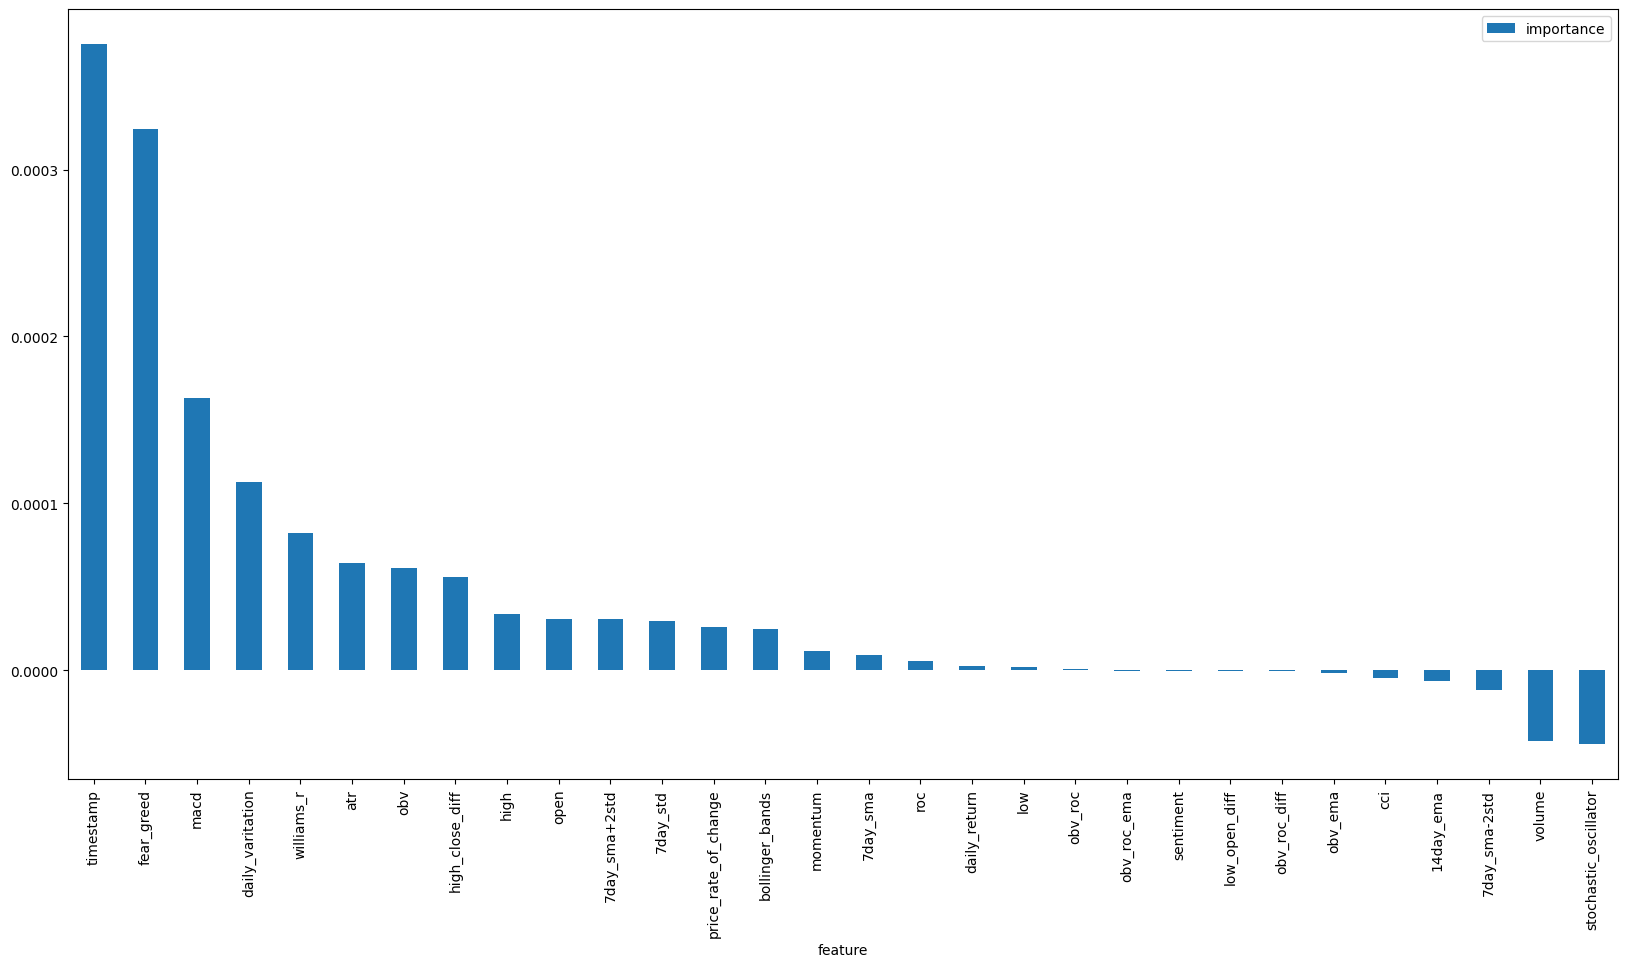

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


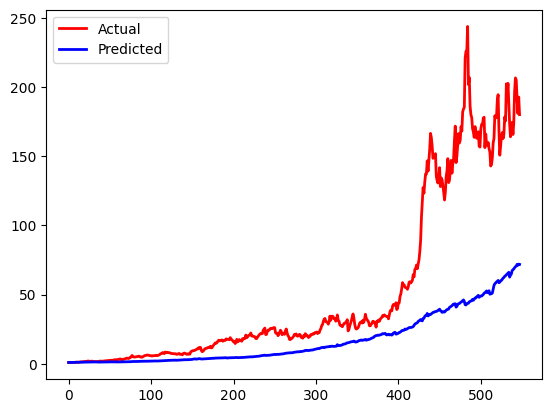

GRU model
Baseline performance: 0.0033859568648040295


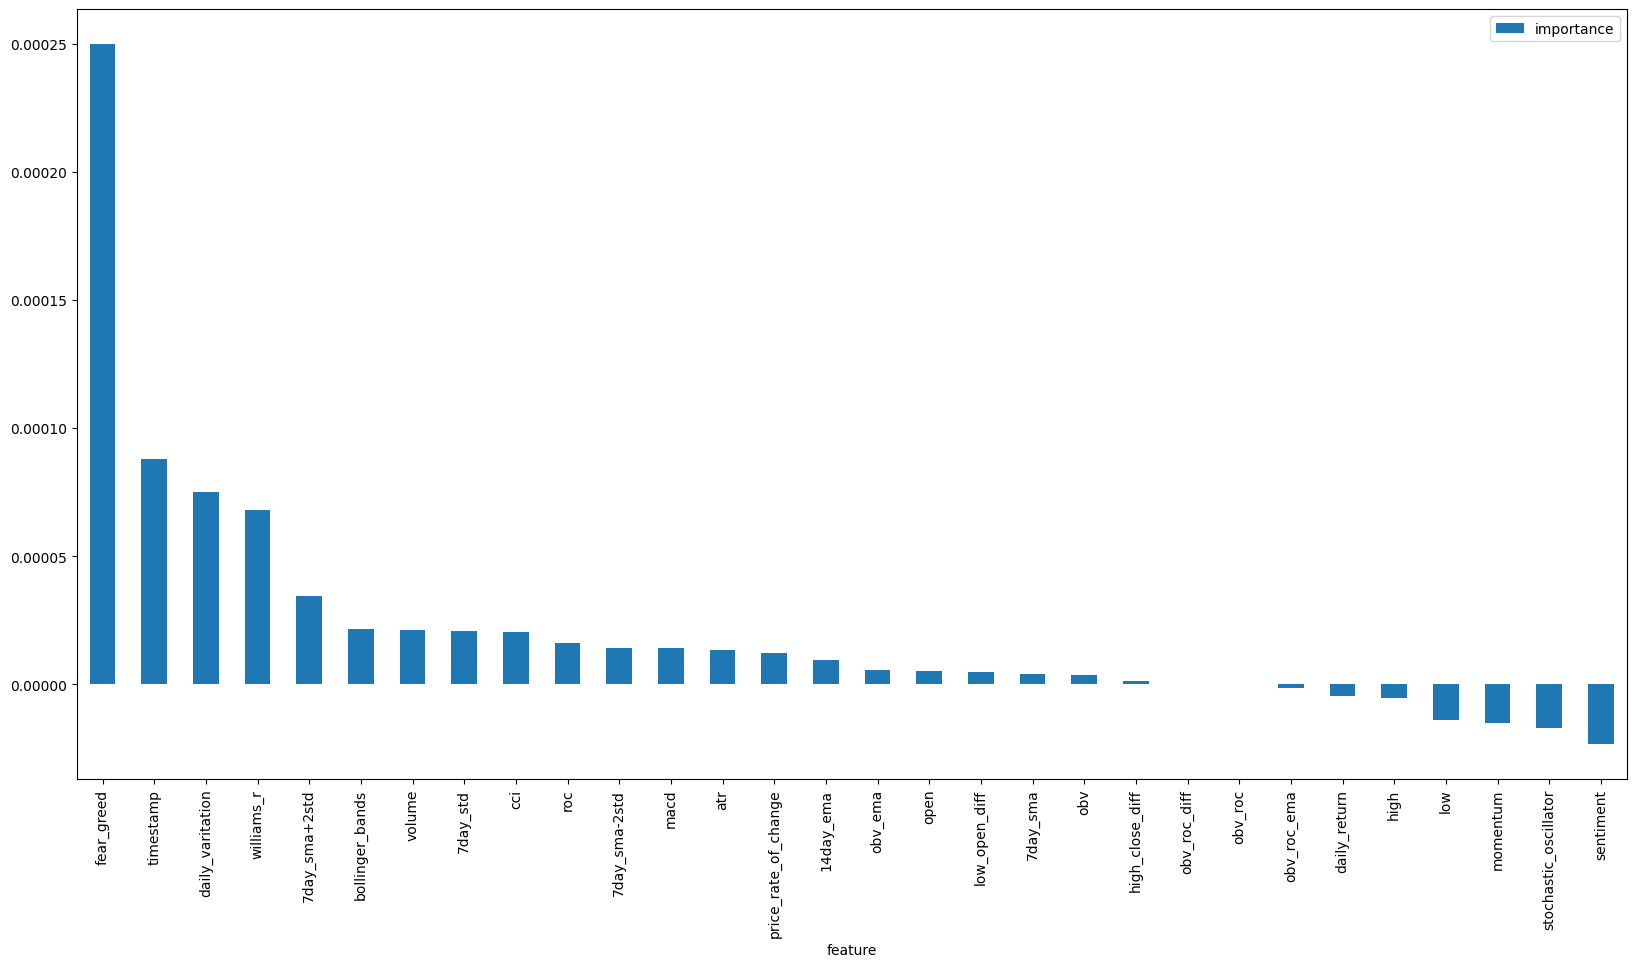

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


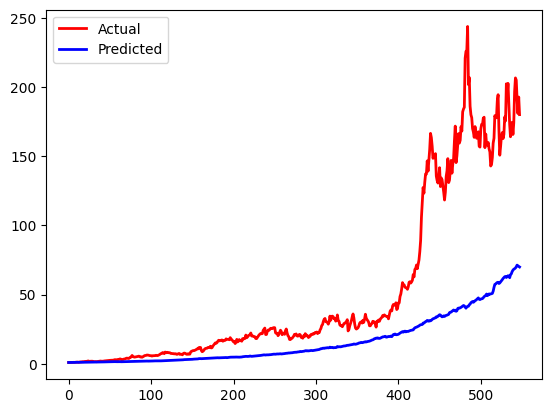

CNN LSTM model
Baseline performance: 0.0029764389619231224


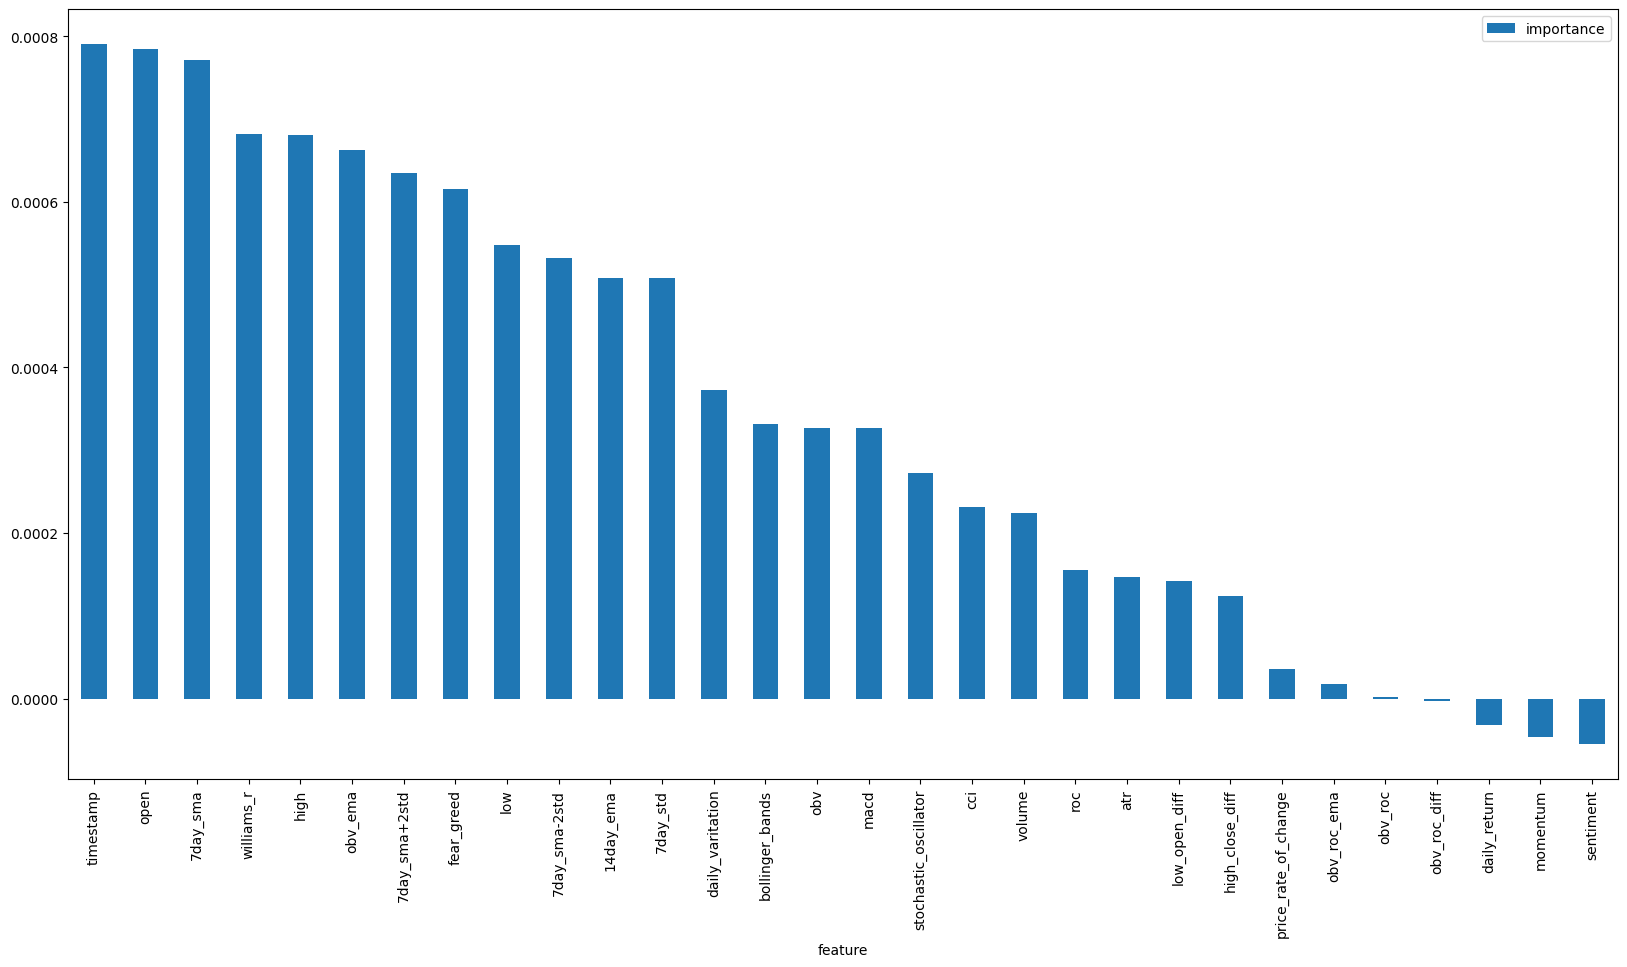

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


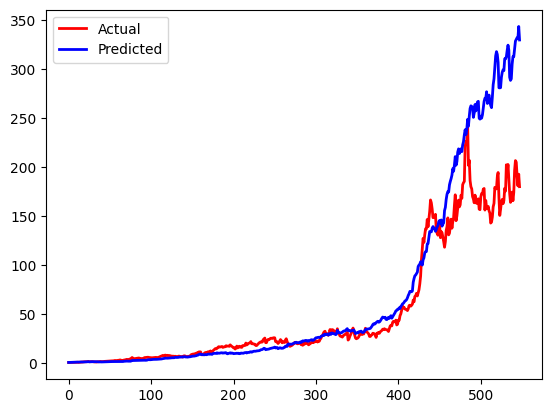

In [19]:
y = data['close'].values
X = data.drop(columns=['close']).values


# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Reshape data for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

enhanced_lstm = create_enhanced_lstm_model((X_train.shape[1], X_train.shape[2]))
gru_model = create_gru_model((X_train.shape[1], X_train.shape[2]))
cnn_lstm_model = create_cnn_lstm_model((X_train.shape[1], X_train.shape[2]))

print("Enhanced LSTM model")
evaluate_features(X_train, X_test, y_train, y_test, enhanced_lstm)
print("GRU model")
evaluate_features(X_train, X_test, y_train, y_test, gru_model)
print("CNN LSTM model")
evaluate_features(X_train, X_test, y_train, y_test, cnn_lstm_model)
